https://leungyukshing.cn/archives/Gaft-Tutorial.html
https://zhuanlan.zhihu.com/p/29474851

GAFT的模块和遗传算法的结构有紧密的关系。components模块下的是个体和种群。operators下的是一个运算子，包括选择、交叉和变异。分析相关的插件是在pluggin_terfaces和analysis。

In [557]:
# components and operators
from gaft import GAEngine
from gaft.components import BinaryIndividual
from gaft.components import DecimalIndividual
from gaft.components import Population
from gaft.operators import RouletteWheelSelection
from gaft.operators import UniformCrossover
from gaft.operators import FlipBitMutation

In [558]:
from gaft.operators import LinearRankingSelection
from gaft.operators import ExponentialRankingSelection

In [559]:
# Analysis Plugin
from gaft.plugin_interfaces.analysis import OnTheFlyAnalysis

from gaft.analysis.fitness_store import FitnessStore
# Math
from math import sin, cos
import numpy as np
# 我们将用两种方式将分析插件注册到遗传算法引擎中

首先定义个体，这里用的是框架默认提供的BinaryIndividual。如果不符合我们的需求，也可以自定义。
然后是定义种群，一般是传入个体的模板和种群的大小。
最后是初始化种群，初始化种群时会逐个调用个体的初始化函数。

In [560]:
indv_template = DecimalIndividual(ranges=[(0, 10)], eps=0.001)
population = Population(indv_template=indv_template, size=20)
population.init()

运算子在遗传算法中至关重要，运算中设计的好坏直接影响了种群的多样性，从而影响算法最后的结果。
选择：GAFT提供了轮盘赌的选择运算。但是这里有一个bug，当所有个体的fitness都相同时，会报错，改进方法后面会讲。
交叉：交叉运算是构成种群多样性的重要运算。这里用了UniformCrossover，里面有两个参数。pc指的是交叉的概率，推荐范围是[0.25, 1.0]，pe指的是选择到该个体后，每个位置上基因的交换概率，推荐范围是[0.5, 0.7]。
变异：这里用的是FlipBitMutation，也就是按每个位上的基因进行翻转（0变为1，1变为0）。参数是pm指的是变异概率，推荐范围是[0.001, 0.1]

In [561]:
#selection = LinearRankingSelection()
selection = ExponentialRankingSelection()
crossover = UniformCrossover(pc=0.8, pe=0.5)
mutation = FlipBitMutation(pm=0.1)

把前面初始化的一系列个体、种群、运算子都加载到引擎中，包括分析插件。

In [562]:
engine = GAEngine(population=population, selection=selection, crossover=crossover, mutation=mutation, analysis=[FitnessStore])

In [563]:
#@engine.fitness_register
# 定义目标函数
def objective_function(t, r, N, K, t0):
    term1 = r * t * N * (t - (N / K) * t)
    term2 = 1 / (1 + np.exp(-r * (t - t0)))
    return term1 + term2

# 定义适应度函数
#@engine.fitness_register
def fitness_function(individual):
    t = individual[0]
    r = individual[1]
    N = individual[2]
    K = individual[3]
    t0 = individual[4]
    
    # 替换为实际的最小值和最大值
    min_val = 0
    max_val = 100
    
    # 计算原始目标函数值
    original_value = objective_function(t, r, N, K, t0)
    
    # 对目标函数值进行归一化处理
    normalized_value = (original_value - min_val) / (max_val - min_val)
    
    # 将适应度值取负号，以确保算法最大化适应度值，同时最小化目标函数
    return -normalized_value



适应值函数是引导种群筛选掉差解，保留好解的重要工具。适应值高的个体我们认为是好解，所以在这里我们要做的就是把每个解的适应值计算出来。
适应值函数需要注册到引擎，这里的写法是采用注解的方法。
在这个任务中，我们计算的时候一个数学函数的最大值，所以在适应值计算中直接计算这个函数的值即可。

In [564]:
@engine.fitness_register
def fitness(indv):
    t, = indv.solution
    r = 0.1  # 你可以调整 r 的值
    N = 100  # 你可以调整 N 的值
    K = 50   # 你可以调整 K 的值
    t0 = 5   # 你可以调整 t0 的值

    # 替换的方程，取负值
    result = - (r*t*N*(t - N/K*t) + 1/(1 + np.exp(-r*(t - t0))))

    # 计算适应度值范围
    min_val = -1000  # 根据实际情况调整
    max_val = 1000   # 根据实际情况调整

    # 线性归一化
    normalized_result = (result - min_val) / (max_val - min_val)
    print(normalized_result, result, min_val, max_val)
    return float(normalized_result)
print(selection)

In [565]:
"""
@engine.fitness_register
def fitness(indv):
    x, = indv.solution
    return x + 10*sin(5*x) + 7*cos(4*x)
"""

'\n@engine.fitness_register\ndef fitness(indv):\n    x, = indv.solution\n    return x + 10*sin(5*x) + 7*cos(4*x)\n'

In [566]:
@engine.analysis_register
class ConsoleOutput(OnTheFlyAnalysis):
    master_only = True
    interval = 1
    def register_step(self, g, population, engine):
        best_indv = population.best_indv(engine.fitness)
        msg = 'Generation: {}, best fitness: {:.3f}'.format(g, engine.fmax)
        engine.logger.info(msg)

In [567]:
engine.run(ng=50)

0.5591439660027198 118.2879320054394 -1000 1000
0.92917656536017 858.35313072034 -1000 1000
0.535157117259039 70.31423451807812 -1000 1000
0.6074488920181009 214.89778403620176 -1000 1000
0.5404747798810229 80.94955976204562 -1000 1000
0.7601478454526966 520.2956909053931 -1000 1000
0.9348479220256922 869.6958440513845 -1000 1000
0.6569346598288144 313.8693196576286 -1000 1000
0.9667538474902517 933.5076949805034 -1000 1000
0.5512286602482765 102.45732049655314 -1000 1000
0.7267989221155339 453.59784423106765 -1000 1000
0.6236029324998733 247.20586499974655 -1000 1000
0.5495115896949929 99.02317938998597 -1000 1000
0.5087064314925476 17.41286298509507 -1000 1000
0.8914919566675169 782.9839133350338 -1000 1000
0.8079056069445706 615.8112138891411 -1000 1000
0.5168461342005205 33.69226840104109 -1000 1000
0.5424079066651166 84.81581333023317 -1000 1000
0.9044307372101222 808.8614744202447 -1000 1000
0.9831301815908325 966.260363181665 -1000 1000
0.9831301815908325 966.260363181665 -1000 

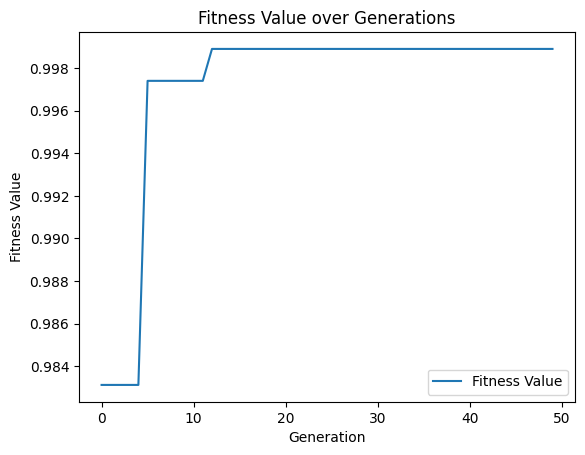

In [568]:
import matplotlib.pyplot as plt

# 从 best_fit.py 文件中读取数据
with open('best_fit.py', 'r') as file:
    content = file.read()

# 执行代码获取 best_fit 数据
exec(content)

# 解析数据
generations = [entry[0] for entry in best_fit]
values = [entry[2] for entry in best_fit]

# 绘制图表
plt.plot(generations, values, label='Fitness Value')
plt.title('Fitness Value over Generations')
plt.xlabel('Generation')
plt.ylabel('Fitness Value')
plt.legend()
plt.show()
